In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from os import makedirs
from os.path import isfile, join
from pathlib import Path, PosixPath
import cv2
from shutil import copy2
from tqdm import tqdm
from tqdm.notebook import tqdm as ntqdm
from random import shuffle

from numpy.typing import ArrayLike
from typing import Any, Iterable, List, Tuple

plt.rcParams['figure.figsize'] = [20, 15]

In [6]:
"""
Yolo format 

dataset.yaml
├── images
│   ├── test
│   ├── train
│   └── val
└── labels
    ├── test
    ├── train
    └── val
    

"""

class Bbox:
    def __init__(self, xyxy: list | tuple, label: int):
        self.x1 = int(xyxy[0])
        self.y1 = int(xyxy[1])
        self.x2 = int(xyxy[2])
        self.y2 = int(xyxy[3])
        self.label = label
        # Fixme: Adapt label to COCO format in future.
        self.pt1 = (self.x1, self.y1)
        self.pt2 = (self.x2, self.y2)
        self.width = abs(self.x2 - self.x1)
        self.height = abs(self.y2 - self.y1)

    def to_coco(self) -> List[int]:
        return [self.x1, self.y1, self.width, self.height]

    def to_yolo(self, img_width: int, img_height: int) -> List[float]:
        x_cen = self.x1 + self.width/2
        y_cen = self.y1 + self.height/2
        x_cen = x_cen / img_width
        y_cen = y_cen / img_height
        width = self.width / img_width
        height = self.height / img_height
        return [x_cen, y_cen, width, height]
    
    def draw(self, img: ArrayLike, color: tuple = (255, 0, 0)) -> ArrayLike:
        img = cv2.rectangle(img, self.pt1, self.pt2, color, 2)
        return img

class Segment:
    def __init__(self, polygon: List[float | int], label: int):
        self.polygon = polygon
        self.pts = self.chunk(polygon)
        self.label = label
        
    def chunk(self, arr: List) -> List[ArrayLike]:
        return [np.array(arr[i:i + 2]).reshape((-1,1,2)).astype(np.int32) for i in range(0, len(arr), 2)]

    def segment_to_yolo(self, img_w, img_h):
        text = ""
        for i, p in enumerate(self.polygon):
            if i % 2 == 0: # x points / img_w
                text += f" {p/img_w:.3f}"
            else: # y points / img_h
                text += f" {p/img_h:.3f}"
        return text
    
    def get_bbox(self) -> Bbox:
        Xs = [int(item) for i, item in enumerate(self.polygon) if i%2 == 0]
        Ys = [int(item) for i, item in enumerate(self.polygon) if i%2 == 1]
        x1, y1 = max(Xs), max(Ys)
        x2, y2 = min(Xs), min(Ys)
        bbox = Bbox([x1, y1, x2, y2], self.label)
        return bbox
    
    def draw(self, img: ArrayLike, color: tuple = (0, 255, 0), draw_bbox = True) -> ArrayLike:
        img = cv2.drawContours(img, self.pts, -1, color, 3)
        bbox: Bbox = self.get_bbox()
        if draw_bbox:
            img = bbox.draw(img, color=color)
        return img


class ImageAnnot:
    # Fixme: Adapt the framework for training bbox annotated project. right now it is decent for segmentation project.
    # Decouple Segment with Bbox.
    def __init__(self, img_path: str | PosixPath):
        self.img_path = Path(img_path)
        assert self.img_path.is_file()
        self.name = self.img_path.name
        self.segments = []
        self.img_w, self.img_h = self.get_img_size()
    
    def get_img_size(self):
        img = cv2.imread(self.img_path.as_posix())
        return img.shape[1], img.shape[0]
        
    def add_segment(self, segment: Segment) -> None:
        self.segments.append(segment)

    def get_yolo_format(self, only_bboxes=True):
        """
        the first five numbers still encode the class index and 
        bounding box information. The rest of the numbers encode 
        the boundary of the object that we are trying to segment. 
        Starting from the 6th number, we have space-separated 
        x-y coordinates for each point on the boundary of the 
        object for the segmentation mask.
        
        """
        temp = ""
        for i, item in enumerate(self.segments):
            label = item.label
            x_cen, y_cen, w, h = item.get_bbox().to_yolo(self.img_w, self.img_h)
            temp = f"{label} {x_cen} {y_cen} {w} {h}"
            
            if not only_bboxes:
                segment_txt = item.segment_to_yolo(self.img_w, self.img_h)
                temp += segment_txt

            if i != len(self.segments)-1:
                temp += '\n'
        return temp

    def save_labels(self, save_path: str = "base_dir", train: bool = True, only_bboxes: bool = True):
        output = self.get_yolo_format(only_bboxes=only_bboxes)
        file_name = self.img_path.stem
        
        if train:
            img_path = join(save_path, 'images', 'train')
            label_path = join(save_path, 'labels', 'train')
        else:
            img_path = join(save_path, 'images', 'val')
            label_path = join(save_path, 'labels', 'val')

        makedirs(label_path, exist_ok=True)
        makedirs(img_path, exist_ok=True)
        
        label_path = join(label_path, file_name + '.txt')
        copy2(self.img_path.as_posix(), img_path)
        with open(label_path, 'w') as file:
            file.write(output)
        
    def get_coco_format(self):
        pass

    def img_show(self, color: tuple = (0, 255, 0)):
        img = cv2.imread(self.img_path.as_posix())
        img = cv2.cvtColor(img, 4)
        for segment in self.segments:
            img = segment.draw(img, color=color, draw_bbox=True)
        return img




In [9]:
len(all_images)

730

In [11]:
train_size

0.8

In [14]:
int(len(all_images) * train_size)

584

In [15]:
# Read json
image_path = 'ball_data/images'
js = json.load(open('ball_data/annotations.json'))

# Convert it to the input array.
img_annots = []
save_path = 'data'
# pbar = tqdm(total=len(js))
all_images = list(Path(image_path).glob('*.png')) + list(Path(image_path).glob('*.jpg'))
shuffle(all_images)
# Fixme: Create some shuffling step

# all_images = all_images[:40].
train_size = 0.91
train_index = int(len(all_images) * train_size)

for i, image_path in enumerate(ntqdm(all_images)):
    # pbar.update(1)
    img_annot = ImageAnnot(image_path)
    item = js[image_path.name] if image_path.name in js.keys() else None
    polygons = [item['points'] for item in item['instances'] if item['type'] == 'polygon'] if item is not None else []
    for ii, polygon in enumerate(polygons):
        seg = Segment(polygon, label=0)
        img_annot.add_segment(seg)

    if i < train_index:
        img_annot.save_labels(save_path=save_path, train=True, only_bboxes=True)
    else:
        img_annot.save_labels(save_path=save_path, train=False, only_bboxes=True)
    img_annots.append(img_annot)


# Generate the annotations

# Save them in specific directory

  0%|          | 0/730 [00:00<?, ?it/s]

In [8]:
train_index

912

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

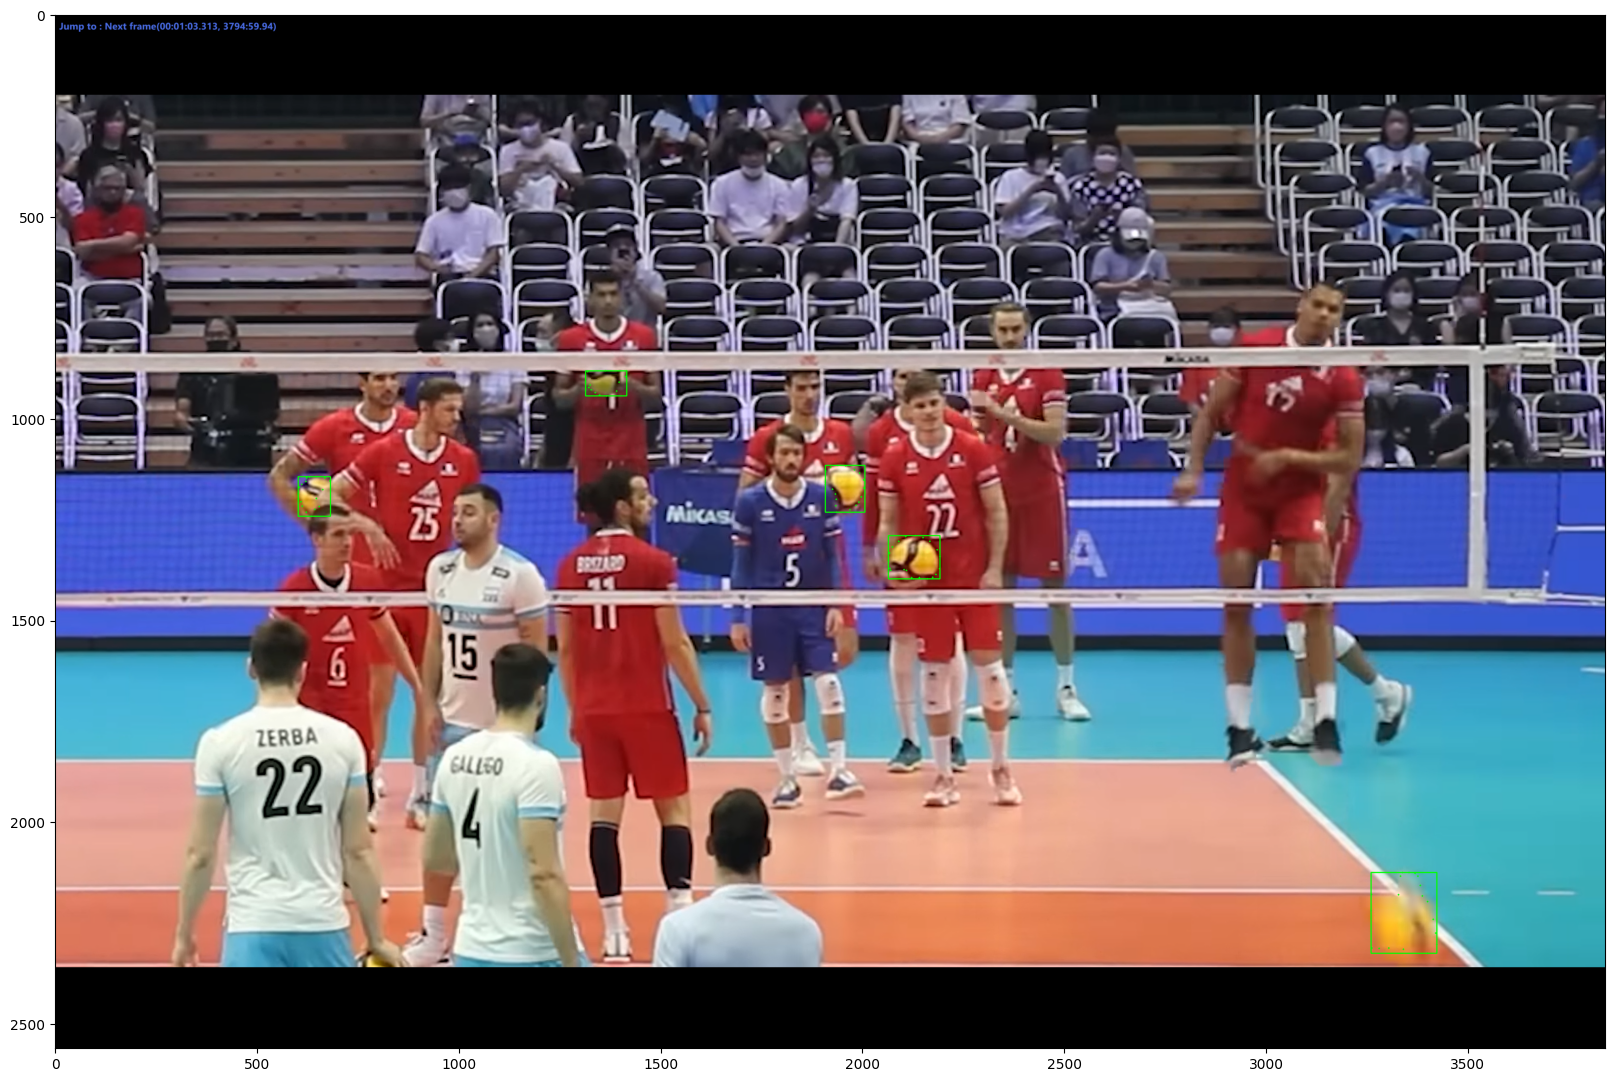

In [63]:
from random import choice
ch = choice(img_annots)
f = ch.img_show(color=(0, 255, 0))
plt.imshow(f)